# Distributed portals with Elixir

## Introduction

This notebook is a fast-paced introduction to the Elixir
programming language. We will explore both basic and advanced
concepts to implement our own version of [the Portal
game](http://en.wikipedia.org/wiki/Portal_(video_game)) to
transfer data across notebooks using Elixir's distribution
capabilities.

For a more structured introduction to the language, see [Elixir's
Getting Started guide](https://elixir-lang.org/getting-started/introduction.html)
and [the many learning resources available](https://elixir-lang.org/learning.html).

### The plan ahead

The Portal game consists of a series of puzzles that must be
solved by teleporting the player's character and simple objects
from one place to another.

In order to teleport, the player uses the Portal gun to shoot doors
onto flat planes, like a floor or a wall. Entering one of those doors
teleports you to the other:

![](./images/portal-drop.jpeg)

Our version of the Portal game will use Elixir to shoot doors of
different colors and transfer data between them! We will even learn how
we can distribute doors across different machines in our network:

![](./images/portal-list.jpeg)

Here is what we will learn:

  * Elixir's basic data structures
  * Pattern matching
  * Using agents for state
  * Using structs for custom data structures
  * Extending the language with protocols
  * Supervision trees and applications



At the end of this notebook, we will make the following code work:
    
```ruby
# Shoot two doors: one orange, another blue
Portal.shoot(:orange)
Portal.shoot(:blue)

# Start transferring the list [1, 2, 3, 4] from orange to blue
portal = Portal.transfer(:orange, :blue, [1, 2, 3, 4])

# This will output:
#
#   #Portal<
#          :orange <=> :blue
#     [1, 2, 3, 4] <=> []
#   >

# Now every time we call push_right, data goes to blue
Portal.push_right(portal)

# This will output:
#
#   #Portal<
#          :orange <=> :blue
#        [1, 2, 3] <=> [4]
#   >
```

Intrigued? Let's get started!

## Basic data structures

Elixir has numbers, strings, and variables. Code comments start with `#`:

OUT: BOOOM!!

ERROR: Crash!!

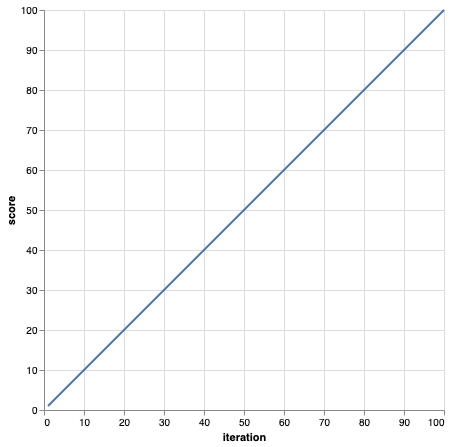

In [3]:
# Numbers
IO.inspect(40 + 2)

# Strings
variable = "hello" <> " world"
IO.inspect(variable)

Executing the cell above prints the number `42` and the string
`"hello world"`. To do so, we called the function `inspect` in
the `IO` module, using the `IO.inspect(...)` notation. This function
prints the given data structure to your terminal - in this case,
our notebook - and returns the value given to it.

Elixir also has three special values, `true`, `false`, and `nil`.
Everything in Elixir is considered to be a truthy value, except for
`false` and `nil`:

OUT: BOOOM!!

ERROR: Crash!!

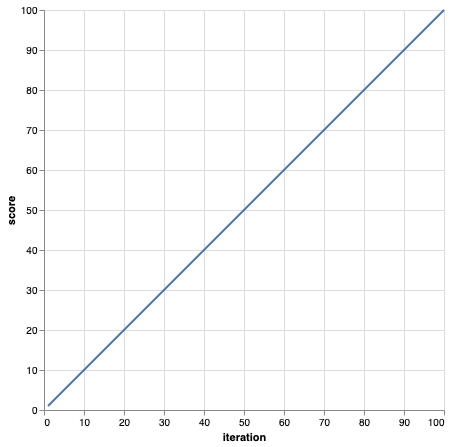

In [2]:
# && is the logical and operator
IO.inspect(true && true)
IO.inspect(13 && 42)

# || is the logical or operator
IO.inspect(true || false)
IO.inspect(nil || 42)

For working with collections of data, Elixir has three data types:

In [ ]:
# Lists (typically hold a dynamic amount of items)
IO.inspect([1, 2, "three"])

# Tuples (typically hold a fixed amount of items)
IO.inspect({:ok, "value"})

# Maps (key-value data structures)
IO.inspect(%{"key" => "value"})

In the snippet above, we also used a new data structure represented
as `:ok`. All values starting with a leading `:` in Elixir are called
**atoms**. Atoms are used as identifiers across the language. Common
atoms are `:ok` and `:error`. Which brings us to the next topic: pattern
matching.

## Pattern matching

The `=` operator in Elixir is a bit different from the ones we see
in other languages:

In [ ]:
x = 1
x

So far so good, but what happens if we invert the operands?

In [ ]:
1 = x

It worked! That's because Elixir tries to match the right side
against the left side. Since both are set to `1`, it works. Let's
try something else:

In [ ]:
2 = x

Now the sides did not match, so we got an error. We use pattern
matching in Elixir to match on collection too. For example, we
can use `[head | tail]` to extract the head (the first element)
and tail (the remaining ones) from a list:

In [ ]:
[head | tail] = [1, 2, 3]
IO.inspect(head)
IO.inspect(tail)

Matching an empty list against `[head | tail]` causes a match error:

In [ ]:
[head | tail] = []

Finally, we can also use the `[head | tail]` expression to add
elements to the head of a list:

In [ ]:
list = [1, 2, 3]
[0 | list]

We can also pattern match on tuples. This is often used to match
on the return types of function calls. For example, take the function
`Date.from_iso8601(string)`, which returns `{:ok, date}` if the
string represents a valid date, in the format `YYYY-MM-DD`, otherwise
it returns `{:error, reason}`:

In [ ]:
# A valid date
Date.from_iso8601("2020-02-29")

In [ ]:
# An invalid date
Date.from_iso8601("2020-02-30")

Now, what happens if we want our code to behave differently depending
if the date is valid or not? We can use `case` to pattern match on
the different tuples. This is also a good opportunity to use Livebook's
inputs to pass different values to our code:

```ruby
# Read the date input, which returns something like "2020-02-30\n"
input = IO.gets("Date: ")

# So we trim the newline from the input value
trimmed = String.trim(input)

# And then match on the return value
case Date.from_iso8601(trimmed) do
  {:ok, date} ->
    "We got a valid date: #{inspect(date)}"

  {:error, reason} ->
    "Oh no, the date is invalid. Reason: #{inspect(reason)}"
end
```

We have been using `IO.inspect` to write values out of the notebook
and here we used `IO.gets` to read data in. The string passed to
`IO.gets` must have the same suffix as the input name. The returned
string is always appended with a newline. Then we remove the trailing new
line and use `case` to pattern match on the different outcomes of the
`Date.from_iso8601` function. We say the `case` above has two clauses,
one matching on `{:ok, date}` and another on `{:error, reason}`.
Try changing the input and re-executing the cell to see how the outcome
changes.

Finally, we can also pattern match on maps. This is used to extract the
values for the given keys:

In [ ]:
map = %{:elixir => :functional, :python => :object_oriented}
%{:elixir => type} = map

If the key does not exist on the map, it raises:

In [ ]:
%{:c => type} = map

With pattern matching out of the way, we are ready to start our Portal
implementation!

## Modeling portal doors with Agents

Elixir data structures are immutable. In the examples above, we never
mutated the list. We can break a list apart or add new elements to the
head, but the original list is never modified.

That said, when we need to keep some sort of state, like the data
transfering through a portal, we must use an abstraction that stores
this state for us. One such abstraction in Elixir is called an agent.
Before we use agents, we need to briefly talk about anonymous functions.

Anonymous functions are a mechanism to represent pieces of code that we
can pass around and execute later on:adder = fn a, b -> a + b end

In [ ]:
adder = fn a, b -> a + b end

An anonymous function is delimited by the words `fn` and `end` and an
arrow `->` is used to separate the arguments from the anonymous function
body. We can now call the anonymous function above multiple times by
providing two numbers as inputs:

In [ ]:
adder.(1, 2)

In [ ]:
adder.(3, 5)

In Elixir, we also use anonymous functions to initialize, get, and update
the agent state:

In [ ]:
{:ok, agent} = Agent.start_link(fn -> [] end)

In the example above, we created a new agent, passing a function that
returns the initial state of an empty list. The agent returns
`{:ok, #PID<...>}`, where PID stands for a process identifier, which
uniquely identifies the agent. Elixir has many abstractions for concurrency,
such as agents, tasks, generic servers, but at the end of the day they all
boil down to processes. When we say processes in Elixir, we don't mean
Operating System processes, but rather Elixir Processes, which are lightweight
and isolated, allowing us to run hundreds of thousands of them on the same
machine.

We store the agent's PID in the `agent` variable, which allows us to
send messages to get the agent's state:

In [ ]:
Agent.get(agent, fn list -> list end)

As well as update it before reading again:

In [ ]:
Agent.update(agent, fn list -> [0 | list] end)
Agent.get(agent, fn list -> list end)

We will use agents to implement our portal doors.

Whenever we need to encapsulate logic in Elixir, we create modules,
which are essentially a collection of functions. We define modules
with `defmodule` and functions with `def`. Our functions will
encapsulate the logic to interact with the agent, using the API we
learned in the cells above:

In [ ]:
defmodule Portal.Door do
  use Agent

  def start_link(color) when is_atom(color) do
    Agent.start_link(fn -> [] end, name: color)
  end

  def get(door) do
    Agent.get(door, fn list -> list end)
  end

  def push(door, value) do
    Agent.update(door, fn list -> [value | list] end)
  end

  def pop(door) do
    Agent.get_and_update(door, fn list ->
      case list do
        [h | t] -> {{:ok, h}, t}
        [] -> {:error, []}
      end
    end)
  end

  def stop(door) do
    Agent.stop(door)
  end
end

We declare a module by giving it a name, in this case, `Portal.Door`.
At the top of the module, we say `use Agent`, which brings some
`Agent`-related functionality into the module.

The first function is `start_link`, which we often refer to as
`start_link/1`, where the number 1 is called the "arity" of the
function and it indicates the number of arguments it receives.
Then we check that the argument is an atom and proceed to call
`Agent.start_link/2`, as we did earlier in this section, except we are
now passing `name: color` as an argument. By giving a name to the
Agent, we can refer to it anywhere by its name, instead of using its
PID.

The next two functions, `get/1` and `push/2` perform simple operation
to the agent, reading its state and adding a new element respectively.

Let's take a look at them:

In [ ]:
Portal.Door.start_link(:pink)
Portal.Door.get(:pink)

Note how we didn't need to store the PID anywhere and we can use the
atom `:pink` to refer to the door and read its state. If the door
already exists, and we try to start another one with the same name,
it returns an `{:error, reason}` tuple instead of `{:ok, pid}`:

In [ ]:
Portal.Door.start_link(:pink)

Next, let's push some events:

In [ ]:
Portal.Door.push(:pink, 1)
Portal.Door.push(:pink, 2)
Portal.Door.get(:pink)

We pushed some events and they show up in our state. Although, note
they appear in reverse order. That's because we are always adding
new entries to the top of the list.

The fourth function we defined is called `pop/1`. If there is any
item in the agent, it takes the head of the list and returns it
wrapped in a `{:ok, value}` tuple. However, if the list is empty,
it returns `:error`.

In [ ]:
IO.inspect(Portal.Door.pop(:pink))
IO.inspect(Portal.Door.pop(:pink))
IO.inspect(Portal.Door.pop(:pink))

Portal.Door.get(:pink)

Finally, the last function, `stop/1`, simply terminates the agent,
effectively closing the door. Let's try it:

In [ ]:
Portal.Door.stop(:pink)

Now, if we try to do anything with it, it will raise:

In [ ]:
Portal.Door.get(:pink)

Note the error message points out why the operation did not work, great!

## Portal transfers

Our portal doors are ready so it is time to start working on portal
transfers! In order to store the portal data, we are going to create a
struct named `Portal`. Let's first learn what structs are about.

Structs define data structures with pre-defined keys. The keys are verified
at compilation time, so if you make a typo in the key name, you get an error
early on. Structs are defined inside modules, by calling the `defstruct` with
a list of atom keys. Let's define a `User` struct with the fields `:name`
and `:age`:

In [ ]:
defmodule User do
  defstruct [:name, :age]
end

Now, we can create structs using the `%User{...}` notation:

In [ ]:
user = %User{name: "john doe", age: 27}

We can access struct fields using the `struct.field` syntax:

In [ ]:
user.name

We can pattern match on structs too:

In [ ]:
%User{age: age} = user
age

Finally, let's see what happens if we do a typo in a field:

In [ ]:
%User{agee: age} = user

Now we are ready to define our `Portal` struct. It will have
two fields, `:left` and `:right`, which point respectively to
the portal door on the left and the door on the right. Our goal
is to transfer data from the left door to the right one. The
`Portal` module, where we define our struct, will also have
four other functions:

  * `shoot(color)` - shoots a door of the given color. This is
    a wrapper around `Portal.Door.start_link/1`

  * `transfer(left_door, right_door, data)` - starts a transfer
    by loading the given `data` to `left_door` and returns a
    `Portal` struct

  * `push_right(portal)` - receives a portal and continues the
    transfer by pushing data from the left to the right

  * `close(portal)` - closes the portal by explicitly stopping
    both doors

Let's implement them:

In [ ]:
defmodule Portal do
  defstruct [:left, :right]

  def shoot(color) do
    Portal.Door.start_link(color)
  end

  def transfer(left_door, right_door, data) do
    # First add all data to the portal on the left
    for item <- data do
      Portal.Door.push(left_door, item)
    end

    # Returns a portal struct with the doors
    %Portal{left: left_door, right: right_door}
  end

  def push_right(portal) do
    # See if we can pop data from left. If so, push the
    # popped data to the right. Otherwise, do nothing.
    case Portal.Door.pop(portal.left) do
      :error   -> :ok
      {:ok, h} -> Portal.Door.push(portal.right, h)
    end

    # Let's return the portal itself
    portal
  end

  def close(portal) do
    Portal.Door.stop(portal.left)
    Portal.Door.stop(portal.right)
    :ok
  end
end

The `Portal` modules defines a struct followed by a `shoot/1` function.
The function is just a wrapper around `Portal.Door.start_link/1`. Then
we define the `transfer/3` function, which loads the given data into the
left door and returns a Portal struct. Finally, `push_right/3` gets data
from the door on the left and puts it on the right door. Let's give it a try:

In [ ]:
Portal.shoot(:orange)
Portal.shoot(:blue)
portal = Portal.transfer(:orange, :blue, [1, 2, 3])

The above returns the `%Portal{}` struct. We can check the data has been
loaded into the left door:

In [ ]:
Portal.Door.get(:orange)

Note the list is reversed - and we knew that! - as we always add items
on the top. But we will use that to our advantage soon. Let's start pushing
data to the right:

In [ ]:
Portal.push_right(portal)
Portal.Door.get(:blue)

Since the list is reversed, we can see that we pushed the number `3`
to the right, which is exactly what we expected. If you reevaluate the
cell above, you will see data moving to the right, as our portal doors
are stateful.

Our portal transfer seems to work as expected! Now let's clean up and
close the transfer:

In [ ]:
Portal.close(portal)

We have made some good progress in our implementation, so now let's work
a bit on the presentation. Currently, the Portal is printed as a struct:
`%Portal{left: :orange, right: :blue}`. It would be nice if we actually
had a printed representation of the portal transfer, allowing us to see
the portal processes as we push data.

## Inspecting portals with Protocols

We already know that Elixir data structures data can be printed by Livebook.
After all, when we type `1 + 2`, we get `3` back. However, can we customize
how our own data structures are printed?

Yes, we can! Elixir provides protocols, which allows behaviour to be extended
and implemented for any data type, like our `Portal` struct, at any time.

For example, every time something is printed in Livebook, or in Elixir's
terminal, Elixir uses the `Inspect` protocol. Since protocols can be extended
at any time, by any data type, it means we can implement it for `Portal` too.
We do so by calling `defimpl/2`, passing the protocol name and the data
structure we want to implement the protocol for.

Let's do it:

In [ ]:
defimpl Inspect, for: Portal do
  def inspect(%Portal{left: left, right: right}, _) do
    left_door  = inspect(left)
    right_door = inspect(right)

    left_data  = inspect(Enum.reverse(Portal.Door.get(left)))
    right_data = inspect(Portal.Door.get(right))

    max = max(String.length(left_door), String.length(left_data))

    """
    #Portal<
      #{String.pad_leading(left_door, max)} <=> #{right_door}
      #{String.pad_leading(left_data, max)} <=> #{right_data}
    >\
    """
  end
end

In the snippet above, we have implemented the `Inspect` protocol for the
`Portal` struct. The protocol expects one function named `inspect` to be
implemented. The function expects two arguments, the first is the `Portal`
struct itself and the second is a set of options, which we don't care about
for now.

Then we call `inspect` multiple times, to get a text representation of both
`left` and `right` doors, as well as to get a representation of the data
inside the doors. Finally, we return a string containing the portal presentation
properly aligned.

That's all we need! Let's start a new transfer and see how it goes:

In [ ]:
Portal.shoot(:red)
Portal.shoot(:purple)
portal = Portal.transfer(:red, :purple, [1, 2, 3])

Sweet! Look how Livebook automatically picked up the new representation.
Now feel free to call `push_right` and see what happens:

In [ ]:
Portal.push_right(portal)

Feel free to reevaluate the cell above a couple times. Once you are done,
run the cell below to clean it all up and close the portal:

In [ ]:
Portal.close(portal)